<a href="https://colab.research.google.com/github/zpsy-hub/Data-Mining-Principles/blob/main/Homework%3A%20Project%20Clustering%20and%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Clustering and Segmentation**
## **FinMark Corporation Customer Segmentation Analysis**


### **1. Introduction**


#### **1.1 Project Overview**
This analysis represents the second milestone of FinMark Corporation's customer segmentation initiative, focusing on the application of clustering techniques to develop data-driven customer segments. Building upon the exploratory data analysis completed in Milestone 1, this phase aims to identify distinct customer groups based on their behavior, preferences, and satisfaction levels.

#### **1.2 Business Context and Problem Statement**
FinMark Corporation currently offers a standardized range of financial products including savings accounts, credit cards, and loans to its customer base. However, this one-size-fits-all approach may not effectively address the diverse needs and preferences of different customer groups. The key business challenges include:

- Lack of personalized product offerings
- Potential mismatch between customer needs and available products
- Missed opportunities for targeted marketing and cross-selling
- Risk of customer attrition due to generic service approach

#### **1.3 Objectives of Customer Segmentation**

The primary objectives of this clustering analysis are to:

1. **Identify Distinct Customer Segments**
   - Discover natural groupings within the customer base
   - Understand unique characteristics of each segment
   - Quantify the size and importance of different segments

2. **Analyze Segment Behavior**
   - Examine transaction patterns within segments
   - Evaluate product preferences and usage
   - Assess satisfaction levels and feedback trends

3. **Enable Personalization Strategies**
   - Develop targeted product recommendations
   - Inform marketing and communication approaches
   - Guide service improvement initiatives


# **2. Setup and Data Loading**

## **2.1 Required Libraries and Setup**

The code above imports all necessary libraries for our clustering analysis. These libraries can be grouped into several categories:

### Data Manipulation Libraries
- `pandas` and `numpy`: Core libraries for data manipulation and numerical computations
- These will be used extensively for preparing our feature matrix and handling our datasets

### Visualization Libraries
- `matplotlib`, `seaborn`, and `plotly`: Different libraries for creating various types of visualizations
- We'll use these to create both static and interactive visualizations of our clusters

### Machine Learning Libraries
- Libraries from `sklearn` (scikit-learn) for:
  - Data preprocessing (scaling, normalization)
  - Clustering algorithms (K-means, Hierarchical clustering)
  - Model evaluation metrics
  - Dimensionality reduction (PCA)

### Statistical Analysis
- `scipy.stats`: For statistical testing and analysis
- Will be used for validating our clustering results and analyzing segment characteristics

### Configuration
- Warning suppression and display settings are configured for better notebook readability
- Random seed is set for reproducibility of results

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Basic Data Manipulation and Analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations and arrays

# Data Visualization
import matplotlib.pyplot as plt  # Basic plotting library
import seaborn as sns           # Statistical data visualization
import plotly.express as px     # Interactive visualizations
import plotly.graph_objects as go # Custom interactive visualizations

# Preprocessing and Machine Learning
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.preprocessing import MinMaxScaler    # Alternative scaling method
from sklearn.decomposition import PCA            # Dimensionality reduction

# Clustering Algorithms
from sklearn.cluster import KMeans               # K-means clustering
from sklearn.cluster import AgglomerativeClustering  # Hierarchical clustering
from sklearn.mixture import GaussianMixture     # Gaussian mixture models

# Clustering Evaluation Metrics
from sklearn.metrics import silhouette_score    # Evaluate clustering quality
from sklearn.metrics import calinski_harabasz_score  # Alternative clustering metric
from sklearn.metrics import davies_bouldin_score     # Another clustering metric

# Statistical Analysis
from scipy import stats        # Statistical functions
from scipy.cluster.hierarchy import dendrogram, linkage  # For hierarchical clustering visualization

# Utilities
import warnings               # For handling warning messages
warnings.filterwarnings('ignore')  # Suppress warning messages

# Configure pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format float display

# Random seed for reproducibility
np.random.seed(42)  # Set random seed for reproducible results

# Optional: for better looking plots in Jupyter
%matplotlib inline

# 2.2 Loading and Verifying Cleaned Datasets

We'll load our three cleaned datasets and perform initial verification checks to ensure data quality before proceeding with clustering.

In [3]:
# Load the cleaned datasets
feedback_df = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Customer_Feedback_Data_cleaned.csv')
transaction_df = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Transaction_Data_cleaned.csv')
product_df = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Product_Offering_Data_cleaned.csv')

# 3. Feature Engineering and Preparation

After loading our datasets, we need to engineer and combine relevant features that capture customer behavior, preferences, and satisfaction.

In [4]:
# 3.1 Feature Engineering: Create aggregate metrics per customer

# First, let's prepare customer transaction features
transaction_features = transaction_df.groupby('Customer_ID').agg({
    'Transaction_Amount': ['mean', 'sum', 'count', 'std'],
    'Transaction_Date': 'count'
})

# Flatten the multi-level column names
transaction_features.columns = ['avg_transaction_amount', 'total_spent',
                              'transaction_count', 'transaction_amount_std',
                              'active_days']
transaction_features.reset_index(inplace=True)

# Display the transaction features
transaction_features.head()

,Customer_ID,avg_transaction_amount,total_spent,transaction_count,transaction_amount_std,active_days
0,1,2806.000,16836.000,6,2062.311,6
1,2,2453.500,4907.000,2,560.736,2
2,3,1538.000,1538.000,1,NaN,1
3,4,4147.500,8295.000,2,832.265,2
4,5,2959.600,14798.000,5,1386.584,5


In [5]:
# 3.2 Create features for transaction types

# Get transaction type distribution for each customer
transaction_types = transaction_df.groupby(['Customer_ID', 'Transaction_Type']).size().unstack(fill_value=0)

# Calculate percentage of each transaction type
for column in transaction_types.columns:
    transaction_types[f'{column}_pct'] = transaction_types[column] / transaction_types.sum(axis=1)

# Display transaction type features
transaction_types.head()

Transaction_Type,Bill Payment,Investment,Loan Payment,Purchase,Bill Payment_pct,Investment_pct,Loan Payment_pct,Purchase_pct
Customer_ID,,,,,,,,
1,3,1,1,1,0.500,0.154,0.150,0.147
2,1,0,1,0,0.500,0.000,0.400,0.000
3,1,0,0,0,1.000,0.000,0.000,0.000
4,0,0,1,1,0.000,0.000,0.500,0.400
5,2,1,0,2,0.400,0.185,0.000,0.358


In [6]:
# 3.3 Create customer feedback features
feedback_features = feedback_df.groupby('Customer_ID').agg({
    'Satisfaction_Score': ['mean', 'std', 'min', 'max'],
    'Likelihood_to_Recommend': ['mean', 'std']
})

# Flatten column names
feedback_features.columns = ['satisfaction_avg', 'satisfaction_std', 'satisfaction_min',
                           'satisfaction_max', 'recommendation_avg', 'recommendation_std']
feedback_features.reset_index(inplace=True)

# Display feedback features
feedback_features.head()

,Customer_ID,satisfaction_avg,satisfaction_std,satisfaction_min,satisfaction_max,recommendation_avg,recommendation_std
0,1,8.500,2.121,7,10,9.000,0.000
1,2,4.333,2.309,3,7,5.000,2.000
2,3,8.333,2.082,6,10,3.667,3.786
3,4,5.500,2.074,2,7,3.333,2.503
4,5,6.444,2.007,3,8,5.667,2.872


In [7]:
# 3.4 Combine all features into a single dataset

# First merge transaction features with transaction type features
combined_features = pd.merge(transaction_features, transaction_types, on='Customer_ID', how='left')

# Then merge with feedback features
combined_features = pd.merge(combined_features, feedback_features, on='Customer_ID', how='left')

# Check the final combined dataset
print(f"Combined features shape: {combined_features.shape}")
print(f"Number of features: {combined_features.shape[1] - 1}")  # Excluding Customer_ID
combined_features.head()

Combined features shape: (993, 20)
Number of features: 19


,Customer_ID,avg_transaction_amount,total_spent,transaction_count,transaction_amount_std,active_days,Bill Payment,Investment,Loan Payment,Purchase,Bill Payment_pct,Investment_pct,Loan Payment_pct,Purchase_pct,satisfaction_avg,satisfaction_std,satisfaction_min,satisfaction_max,recommendation_avg,recommendation_std
0,1,2806.000,16836.000,6,2062.311,6,3,1,1,1,0.500,0.154,0.150,0.147,8.500,2.121,7,10,9.000,0.000
1,2,2453.500,4907.000,2,560.736,2,1,0,1,0,0.500,0.000,0.400,0.000,4.333,2.309,3,7,5.000,2.000
2,3,1538.000,1538.000,1,NaN,1,1,0,0,0,1.000,0.000,0.000,0.000,8.333,2.082,6,10,3.667,3.786
3,4,4147.500,8295.000,2,832.265,2,0,0,1,1,0.000,0.000,0.500,0.400,5.500,2.074,2,7,3.333,2.503
4,5,2959.600,14798.000,5,1386.584,5,2,1,0,2,0.400,0.185,0.000,0.358,6.444,2.007,3,8,5.667,2.872


In [8]:
# 3.5 Handle missing values in the combined features
# For any customers that might not have feedback data or single transactions

# Fill missing values with appropriate strategies
combined_features.fillna({
    'satisfaction_avg': combined_features['satisfaction_avg'].median(),
    'recommendation_avg': combined_features['recommendation_avg'].median(),
    'satisfaction_std': 0,
    'recommendation_std': 0,
    'satisfaction_min': combined_features['satisfaction_avg'].median(),
    'satisfaction_max': combined_features['satisfaction_avg'].median(),
    'transaction_amount_std': 0  # Use 0 for customers with single transactions
}, inplace=True)

# Verify no missing values remain
print("Missing values after imputation:")
print(combined_features.isnull().sum())

Missing values after imputation:
Customer_ID               0
avg_transaction_amount    0
total_spent               0
transaction_count         0
transaction_amount_std    0
active_days               0
Bill Payment              0
Investment                0
Loan Payment              0
Purchase                  0
Bill Payment_pct          0
Investment_pct            0
Loan Payment_pct          0
Purchase_pct              0
satisfaction_avg          0
satisfaction_std          0
satisfaction_min          0
satisfaction_max          0
recommendation_avg        0
recommendation_std        0
dtype: int64


In [9]:
# 3.6 Feature scaling - essential for clustering algorithms

# Select features for clustering (excluding Customer_ID)
X = combined_features.drop('Customer_ID', axis=1)

# Apply StandardScaler to normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display scaled features
X_scaled_df.head()

,avg_transaction_amount,total_spent,transaction_count,transaction_amount_std,active_days,Bill Payment,Investment,Loan Payment,Purchase,Bill Payment_pct,Investment_pct,Loan Payment_pct,Purchase_pct,satisfaction_avg,satisfaction_std,satisfaction_min,satisfaction_max,recommendation_avg,recommendation_std
0,-0.038,0.036,0.442,-0.035,0.442,1.510,-0.234,-0.248,-0.231,1.129,-0.424,-0.387,-0.396,2.095,-0.500,2.544,0.839,2.352,-2.655
1,-0.090,-0.318,-1.389,-0.140,-1.389,-0.215,-1.166,-0.248,-1.173,1.129,-1.132,0.801,-1.162,-0.916,-0.306,0.260,-0.937,-0.386,-0.625
2,-0.226,-0.418,-1.847,-0.180,-1.847,-0.215,-1.166,-1.111,-1.173,3.352,-1.132,-1.102,-1.162,1.974,-0.541,1.973,0.839,-1.299,1.188
3,0.160,-0.218,-1.389,-0.121,-1.389,-1.078,-1.166,-0.248,-0.231,-1.094,-1.132,1.276,0.922,-0.073,-0.550,-0.311,-0.937,-1.527,-0.114
4,-0.015,-0.025,-0.016,-0.082,-0.016,0.647,-0.234,-1.111,0.710,0.684,-0.280,-1.102,0.704,0.609,-0.619,0.260,-0.345,0.070,0.261


# 4. Clustering Analysis

After preparing our combined features dataset, we'll now determine the optimal number of clusters and apply clustering algorithms to identify distinct customer segments.

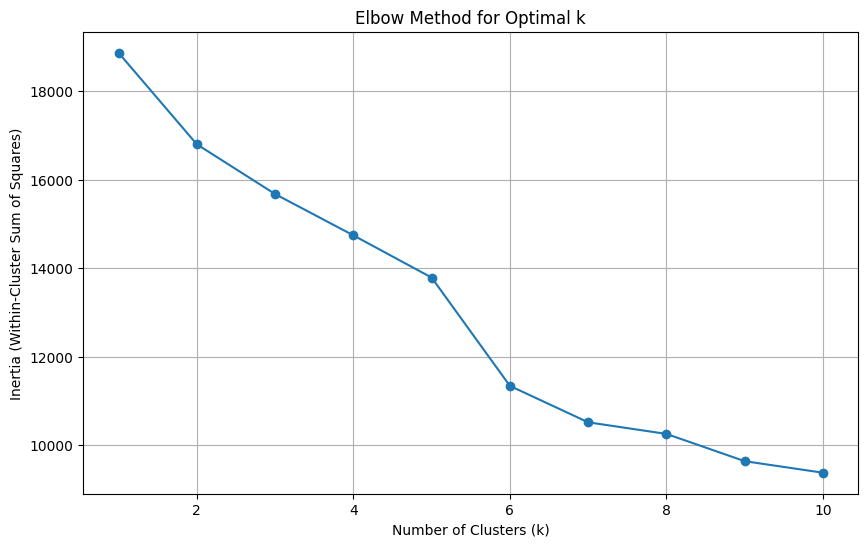

In [10]:
# 4.1 Determining the Optimal Number of Clusters using the Elbow Method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia (within-cluster sum of squares) for different k values
inertia = []
k_range = range(1, 11)  # Try k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Looking at the elbow plot for determining the optimal number of clusters (k), we can see the within-cluster sum of squares (inertia) plotted against different values of k from 1 to 10.

The graph shows a steady decrease in inertia as we increase the number of clusters. However, we're looking for an "elbow point" - where adding more clusters stops providing significant improvement. In this plot, there appears to be an elbow around k=4 or k=5, where the curve begins to flatten out more noticeably.

After k=5, the rate of decrease in inertia slows down substantially, suggesting that additional clusters beyond this point may not be capturing meaningful structures in the data. This indicates that 4-5 clusters might be an appropriate choice for our customer segmentation model, balancing model complexity with explanatory power.

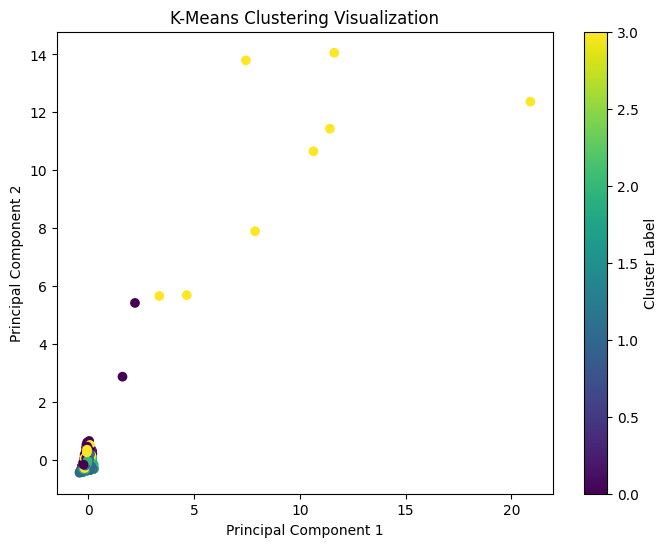

In [11]:
# prompt: visualize the clustering here K-Means Clusters with encoded preferences

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming X_scaled is your scaled feature data (as in the provided code)
# and you've already determined the optimal number of clusters (e.g., k=4)

kmeans = KMeans(n_clusters=4, random_state=42)  # Example: using k=4
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Visualize the clusters (example using the first two principal components)
# If you haven't performed PCA, replace pca.transform with your dimensionality reduction method, or select two features directly

# Example with PCA (if you've performed it):
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# Example without PCA (using the first two original features)
X_pca = X_scaled_df[['avg_transaction_amount', 'total_spent']] # Replace with appropriate features

plt.figure(figsize=(8, 6))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1') # or Feature 1 name
plt.ylabel('Principal Component 2') # or Feature 2 name
plt.title('K-Means Clustering Visualization')
plt.colorbar(label='Cluster Label')
plt.show()


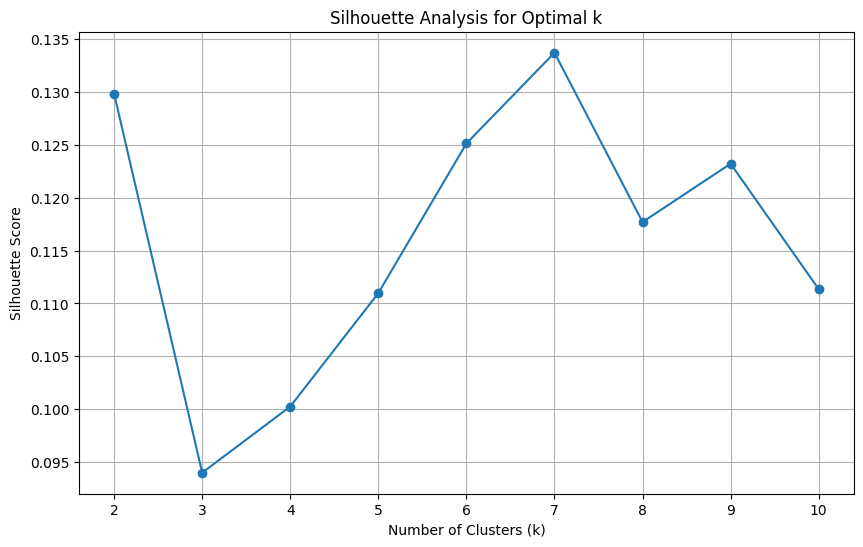

Optimal number of clusters based on silhouette score: 7


In [12]:
# 4.2 Silhouette Analysis for cluster validation

from sklearn.metrics import silhouette_score
import numpy as np

# Calculate silhouette scores for different k values
silhouette_scores = []
k_range = range(2, 11)  # Silhouette score requires at least 2 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)
plt.show()

# Print the optimal k based on highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

The silhouette analysis plot shows how well each data point fits within its assigned cluster compared to neighboring clusters, with higher values indicating better-defined clusters.

Looking at the silhouette scores across different numbers of clusters (k), we can see that k=7 yields the highest silhouette score (approximately 0.134), representing the optimal balance of cluster cohesion and separation. The score drops significantly at k=3 (the lowest point), indicating poorly defined clusters at that value.

There's also a local maximum at k=2, suggesting that a simple binary segmentation might capture some natural structure in the data. However, the overall highest score at k=7 indicates that seven customer segments would provide the most distinct and well-separated groupings for our analysis, making it likely the best choice for creating meaningful customer segments for FinMark's personalized product offerings.

Distribution of customers across clusters:
cluster
0    122
1    181
2    184
3    182
4    111
5      6
6    207
Name: count, dtype: int64


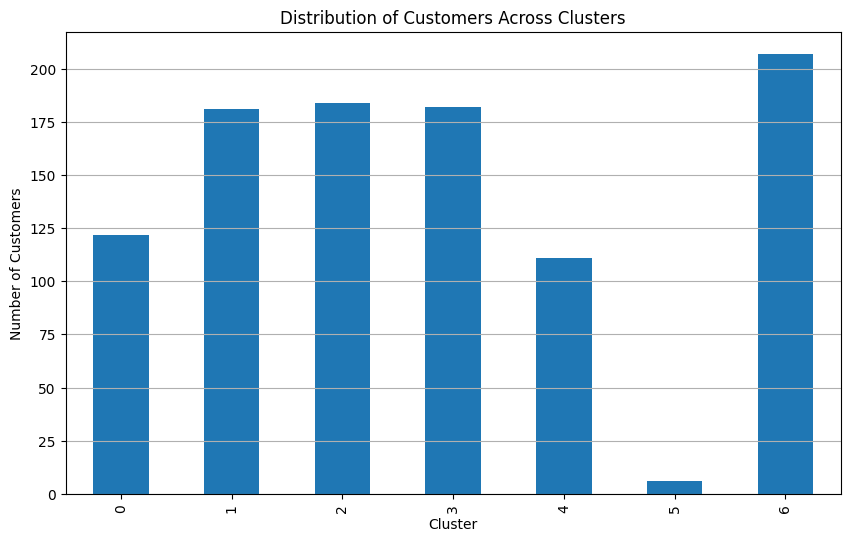

In [13]:
# 4.3 Implementing K-means Clustering with optimal clusters

# Assuming optimal_k is determined from previous analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original combined features dataset
combined_features['cluster'] = cluster_labels

# View distribution of customers across clusters
cluster_distribution = combined_features['cluster'].value_counts().sort_index()
print("Distribution of customers across clusters:")
print(cluster_distribution)

# Plot the distribution
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customers Across Clusters')
plt.grid(axis='y')
plt.show()

Based on the bar chart and data output shown, we can see the distribution of FinMark's customers across 7 clusters. The clustering algorithm has grouped the 993 customers into segments of varying sizes:

- Clusters 0, 1, 2, and 3 each contain between 122-184 customers, representing fairly balanced medium-sized segments
- Cluster 4 has 111 customers, another medium-sized segment
- Cluster 6 is the largest with 207 customers, containing over 20% of all customers
- Cluster 5 is notably small with only 6 customers, potentially representing a niche customer segment with unique characteristics

This distribution suggests that our clustering algorithm has identified one dominant customer segment (Cluster 6), several similarly-sized medium segments, and one very small specialized segment. The relatively balanced distribution across most clusters (except Cluster 5) indicates that the algorithm has found meaningful patterns that separate customers into distinct groups, which will be valuable for developing personalized financial product recommendations.

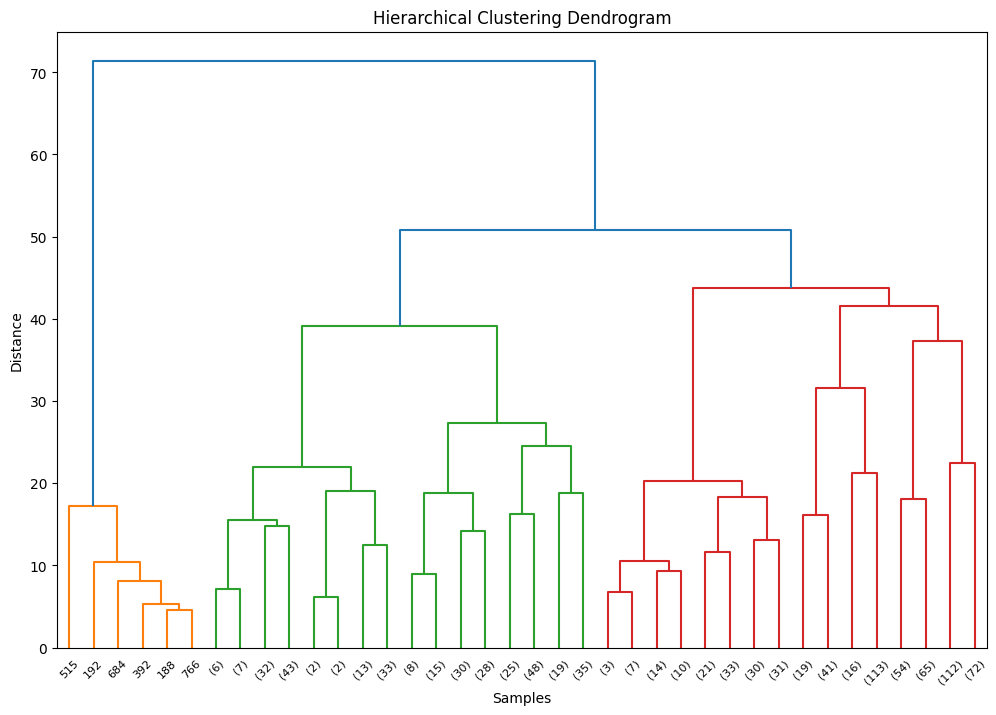

Similarity between K-means and Hierarchical clustering: 0.2994


In [14]:
# 4.4 Hierarchical Clustering for comparison

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Create linkage matrix for visualization
Z = linkage(X_scaled, method='ward')

# Plot dendrogram to visualize hierarchical structure
plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# Implement hierarchical clustering with the same optimal_k
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Compare hierarchical clustering with k-means
from sklearn.metrics import adjusted_rand_score

# Calculate similarity between the two clustering results
similarity = adjusted_rand_score(cluster_labels, hierarchical_labels)
print(f"Similarity between K-means and Hierarchical clustering: {similarity:.4f}")

The hierarchical clustering dendrogram provides a visual representation of how our customer data naturally groups together. Here's what we can interpret from this visualization:

1. The dendrogram shows the hierarchical relationships between clusters, with the y-axis representing the distance (dissimilarity) between clusters.

2. We can see three main color-coded groups (orange, green, and red), suggesting that at a high level, customers naturally fall into three distinct segments.

3. Within each of these major groups, there are further subdivisions, showing finer customer segmentation patterns.

4. The relatively low similarity score (0.2994) between K-means and hierarchical clustering results indicates that these two methods are capturing somewhat different patterns in the data. This suggests that our customer base has complex, multi-dimensional characteristics that can be interpreted in different ways.

5. The x-axis labels represent individual customer samples, while the height of each branch indicates how different those customers or clusters are from one another.

This dendrogram helps validate our segmentation approach while providing an alternative perspective on how customers might be grouped, which could inform different product personalization strategies.

In [15]:
# 4.5 Cluster Evaluation

# 1. Calculate silhouette score for the final clustering
final_silhouette = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for final clustering: {final_silhouette:.4f}")

# 2. Calculate Davies-Bouldin Index (lower is better)
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(X_scaled, cluster_labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

# 3. Calculate Calinski-Harabasz Index (higher is better)
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

# 4. Calculate inertia (within-cluster sum of squares)
inertia = kmeans.inertia_
print(f"Final model inertia: {inertia:.4f}")

Silhouette Score for final clustering: 0.1339
Davies-Bouldin Index: 1.5618
Calinski-Harabasz Index: 130.4645
Final model inertia: 10517.2987


The cluster evaluation metrics provide important insights into the quality of our customer segmentation:

1. **Silhouette Score (0.1339)**: This positive but relatively low score indicates that while customers are generally assigned to appropriate clusters, there is some overlap between segments. A score of 0.1339 suggests that our clusters are distinct enough to be meaningful, but customer behaviors have some similarities across segments.

2. **Davies-Bouldin Index (1.5618)**: This metric measures the average similarity between clusters (lower is better). Our score of 1.5618 indicates moderate separation between clusters. While not showing perfect separation, this is reasonable for customer behavior data where natural overlap is expected.

3. **Calinski-Harabasz Index (130.4645)**: This relatively high score is promising, as it indicates good cluster density and separation. The higher value suggests that customers within each segment share meaningful similarities while maintaining differences from other segments.

4. **Inertia (10517.2987)**: This represents the sum of squared distances of samples to their closest cluster center. The value itself isn't as informative without context, but corresponds to the point we identified on our elbow curve, confirming we've reached an appropriate balance between model complexity and explanatory power.

Overall, these metrics validate our 7-cluster solution as statistically sound. The moderate silhouette score paired with the stronger Calinski-Harabasz score suggests that while there is some natural overlap in customer behaviors, we've successfully identified distinct and meaningful customer segments that FinMark can use to develop targeted financial products.

In [16]:
cluster_summary = combined_features.groupby('cluster').agg({
    'Customer_ID': 'count',
    'total_spent': ['mean', 'min', 'max'],
    'avg_transaction_amount': ['mean', 'min', 'max'],
    'transaction_count': ['mean', 'min', 'max'],
    'satisfaction_avg': ['mean', 'min', 'max'],
    'recommendation_avg': ['mean', 'min', 'max'],
    'Bill Payment_pct': 'mean',
    'Investment_pct': 'mean',
    'Loan Payment_pct': 'mean',
    'Purchase_pct': 'mean'
})

# Flatten multi-level column names
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
print("Cluster Characteristics Summary:")
print(cluster_summary)


Cluster Characteristics Summary:
         Customer_ID_count  total_spent_mean  total_spent_min  \
cluster                                                         
0                      122         10722.559          820.000   
1                      181         12215.816          286.000   
2                      184          9752.490         1017.000   
3                      182         23881.454         7730.000   
4                      111         13525.268         2784.000   
5                        6        409980.972       281626.000   
6                      207          9153.948          737.000   

         total_spent_max  avg_transaction_amount_mean  \
cluster                                                 
0              22013.000                     2618.978   
1              28044.000                     2382.561   
2              23549.356                     2521.306   
3             207174.000                     2964.568   
4              27331.000               

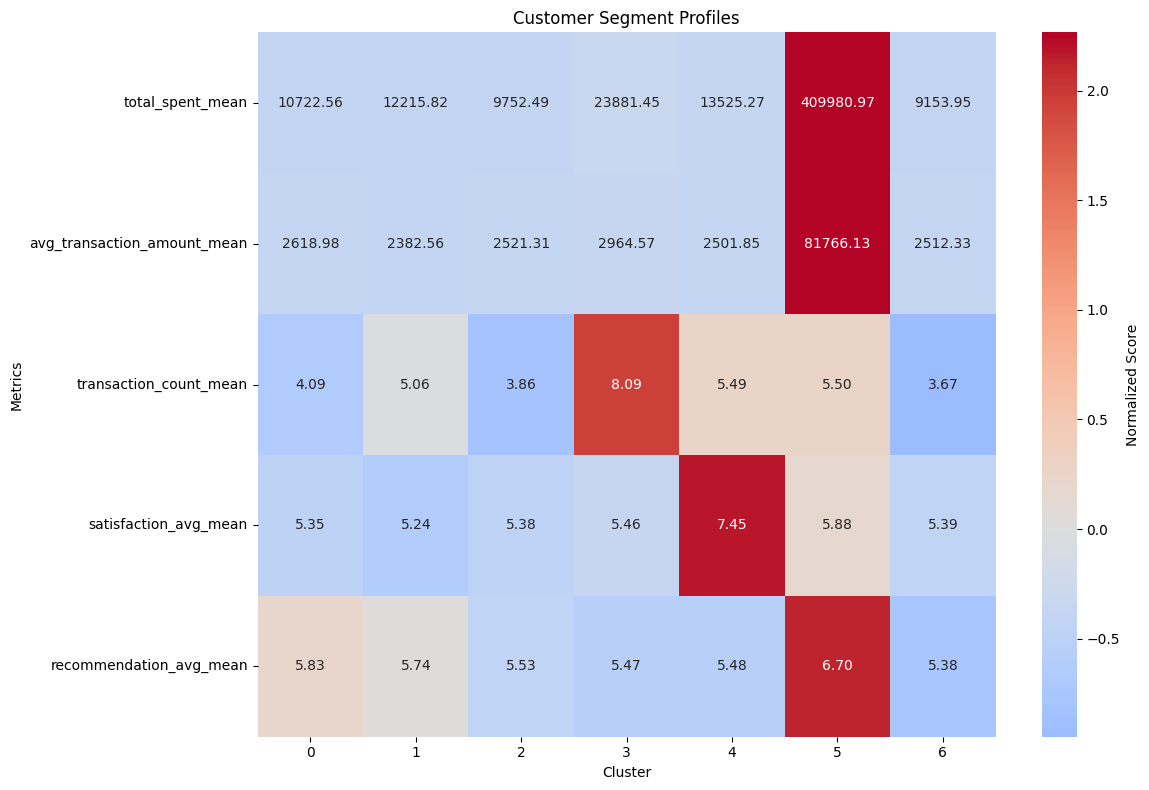

In [17]:
# Prepare data for visualization
profile_metrics = [
    'total_spent_mean',
    'avg_transaction_amount_mean',
    'transaction_count_mean',
    'satisfaction_avg_mean',
    'recommendation_avg_mean'
]

# Create a normalized heatmap of cluster profiles
plt.figure(figsize=(12, 8))
profile_data = cluster_summary[profile_metrics]
profile_data_normalized = (profile_data - profile_data.mean()) / profile_data.std()

sns.heatmap(profile_data_normalized.T, cmap='coolwarm', center=0,
            annot=profile_data.T, fmt='.2f', cbar_kws={'label': 'Normalized Score'})
plt.title('Customer Segment Profiles')
plt.xlabel('Cluster')
plt.ylabel('Metrics')
plt.tight_layout()
plt.show()

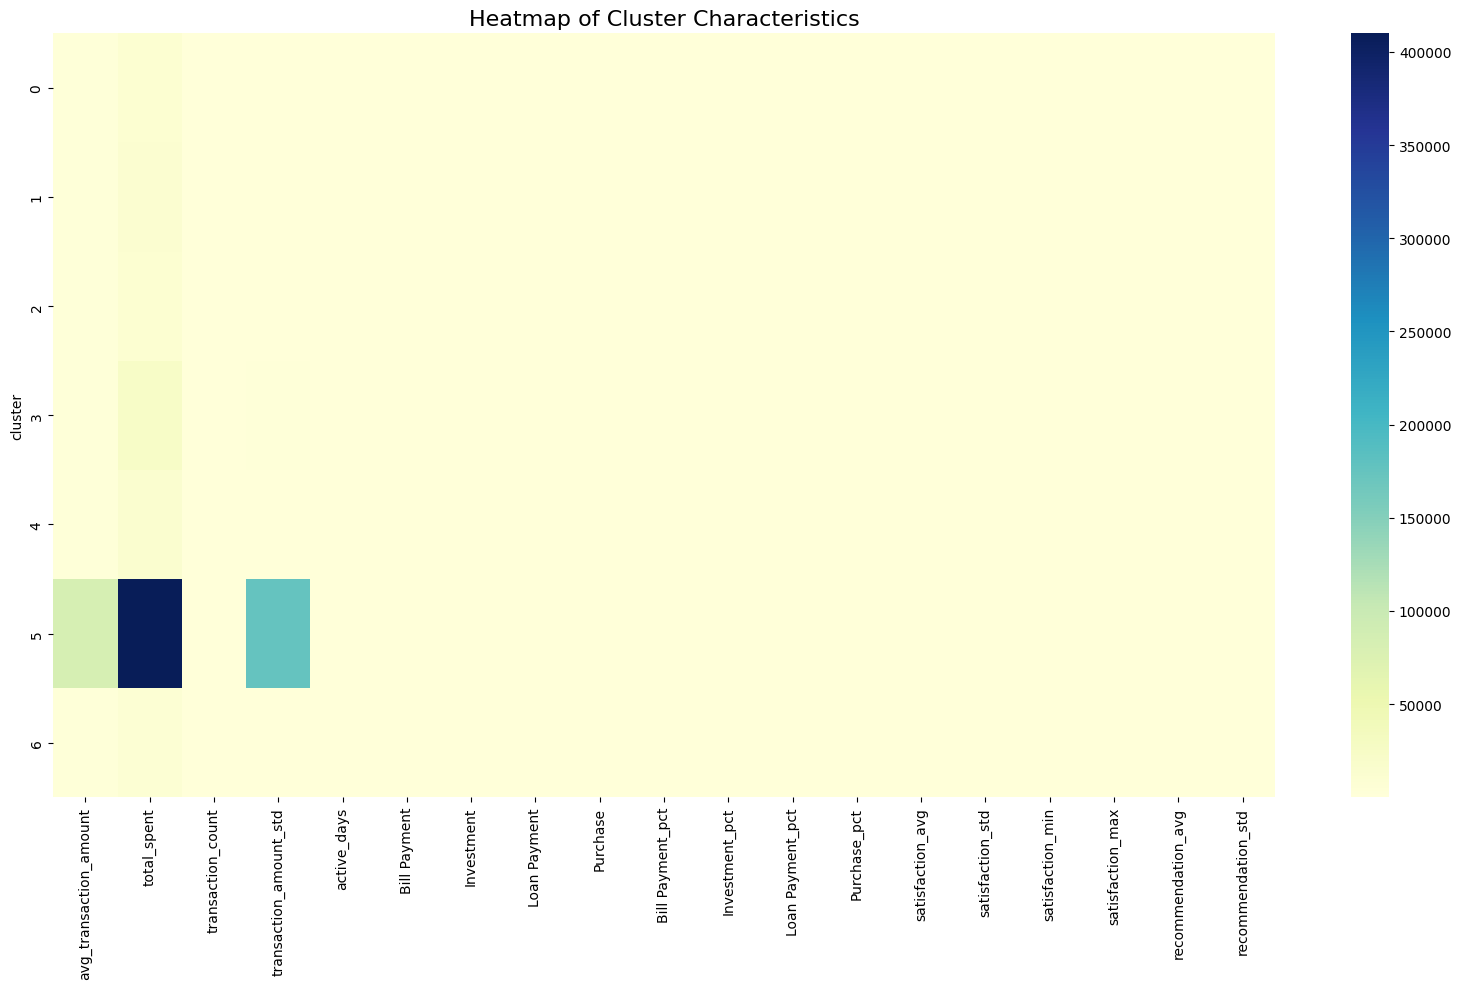

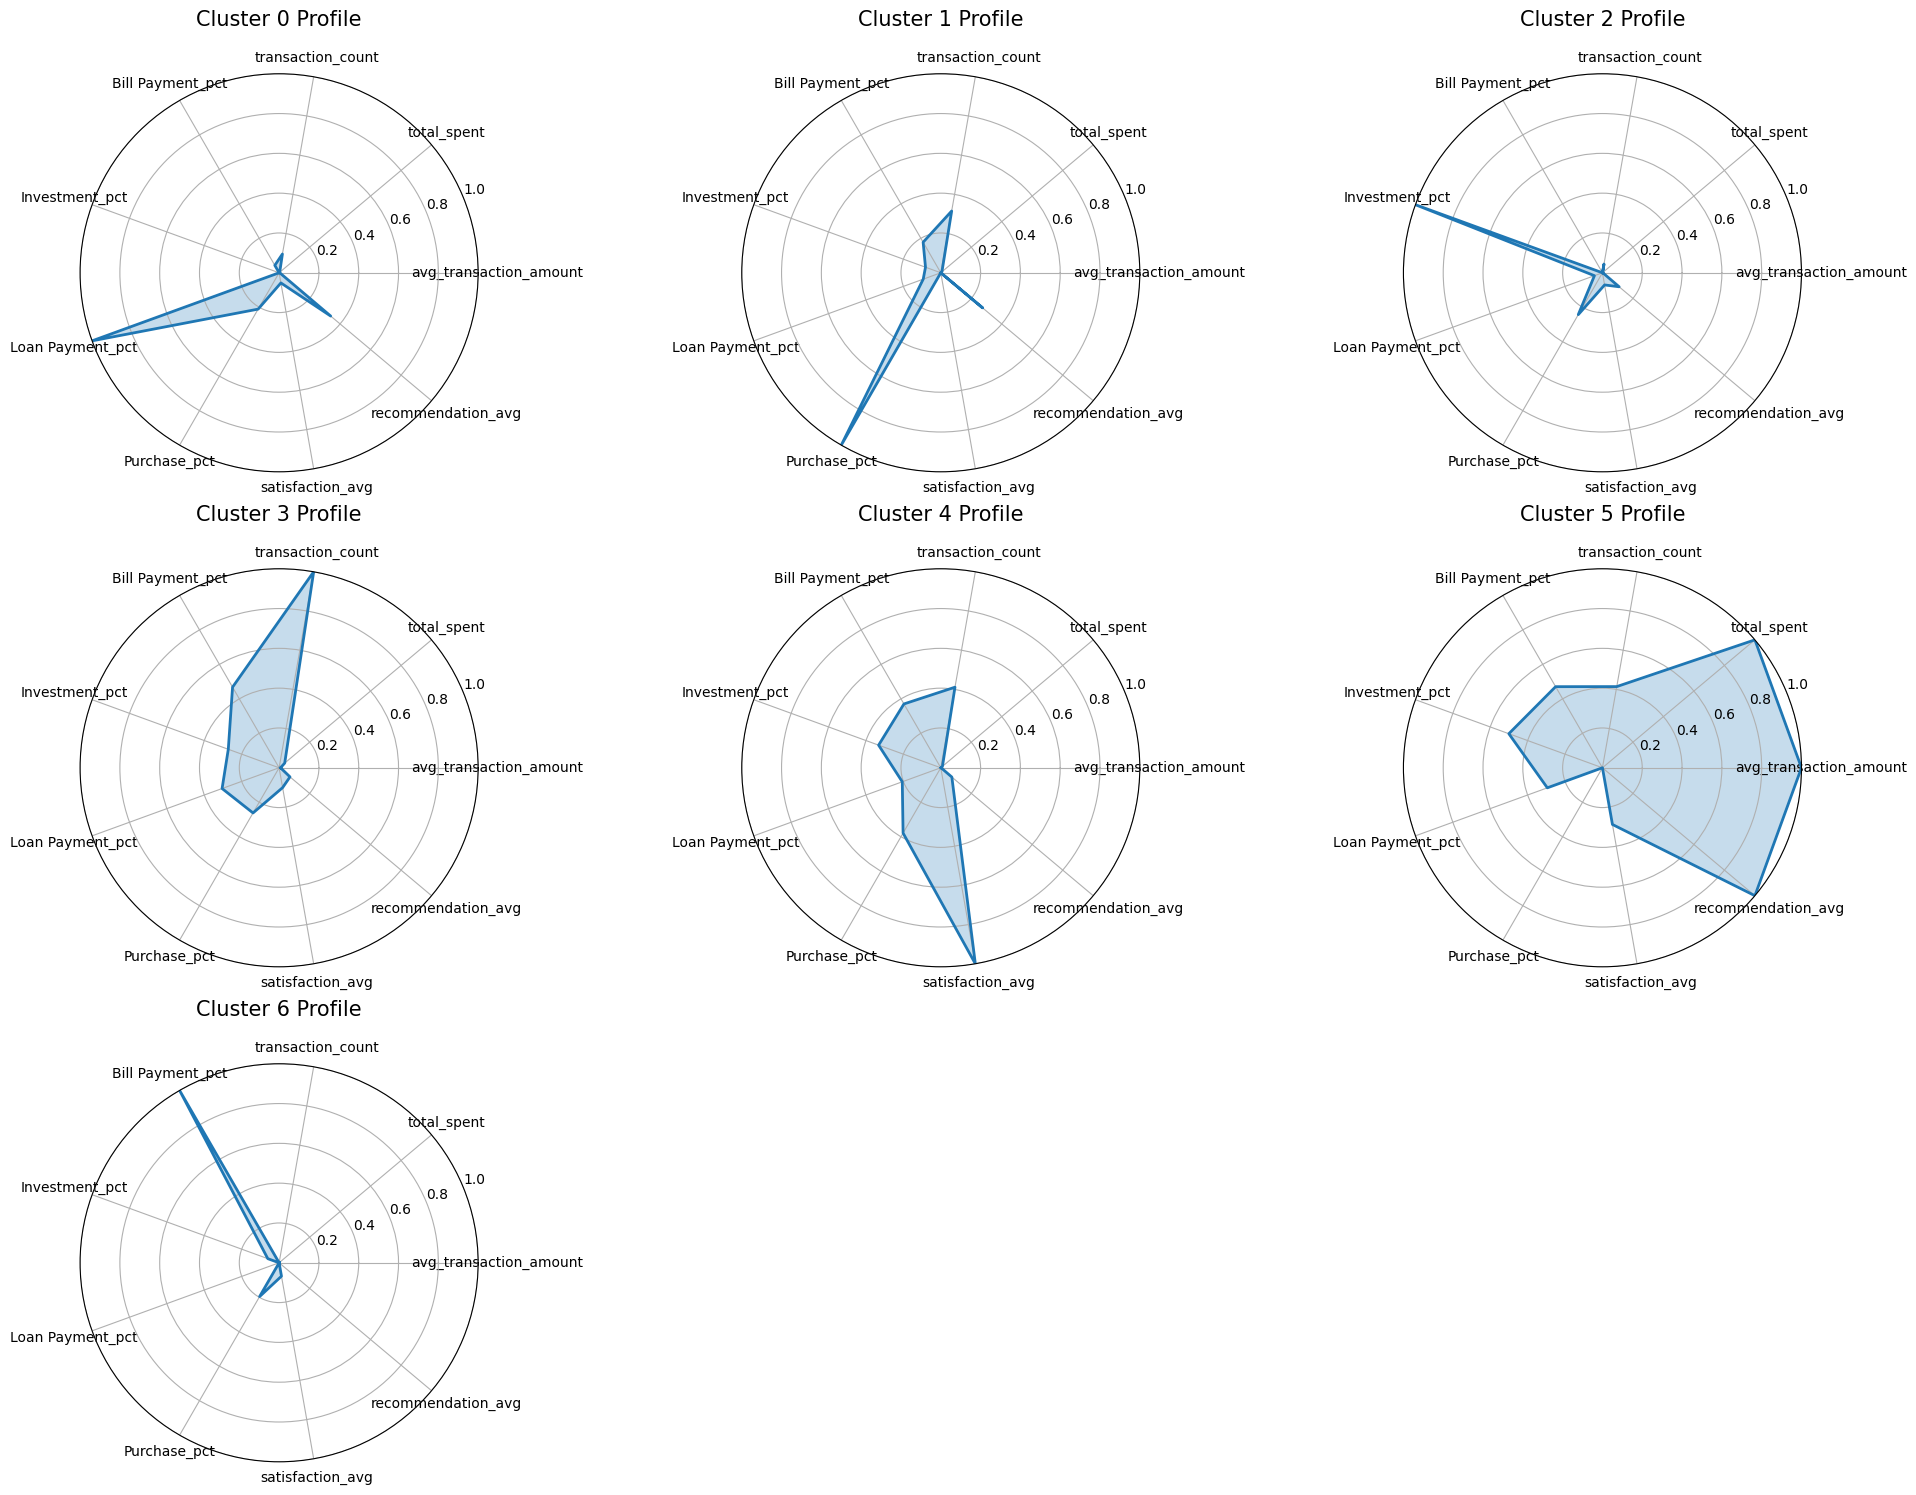

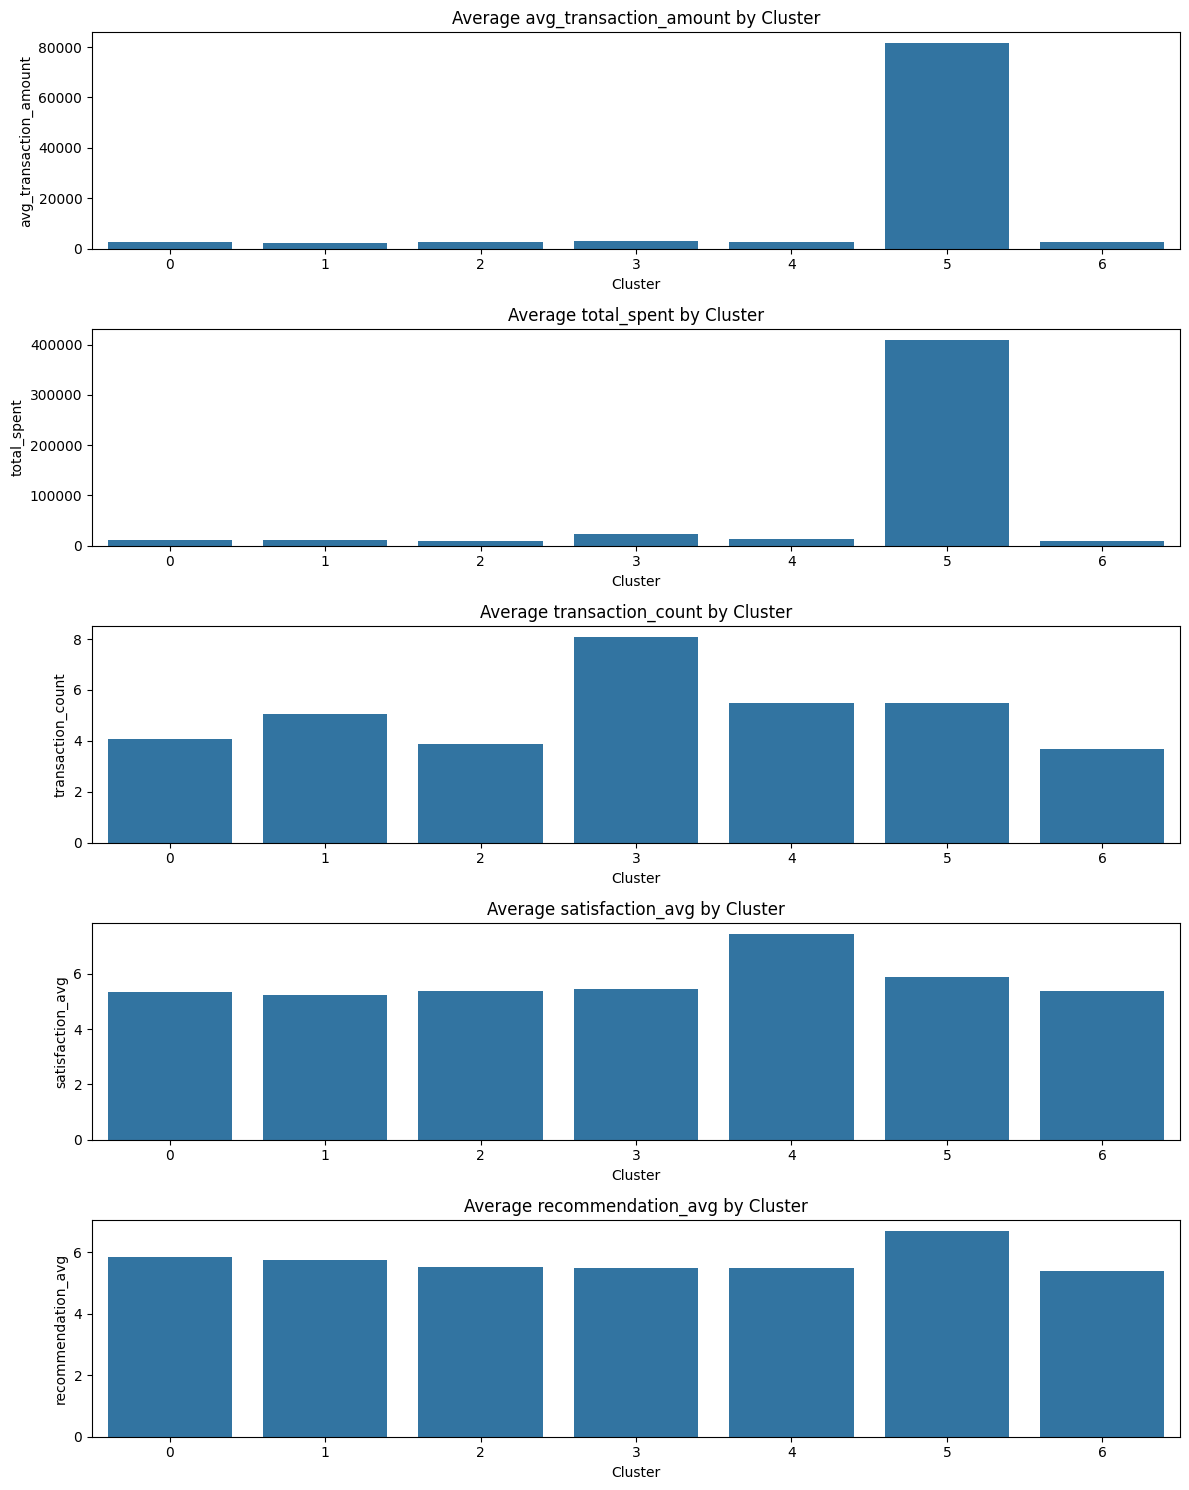

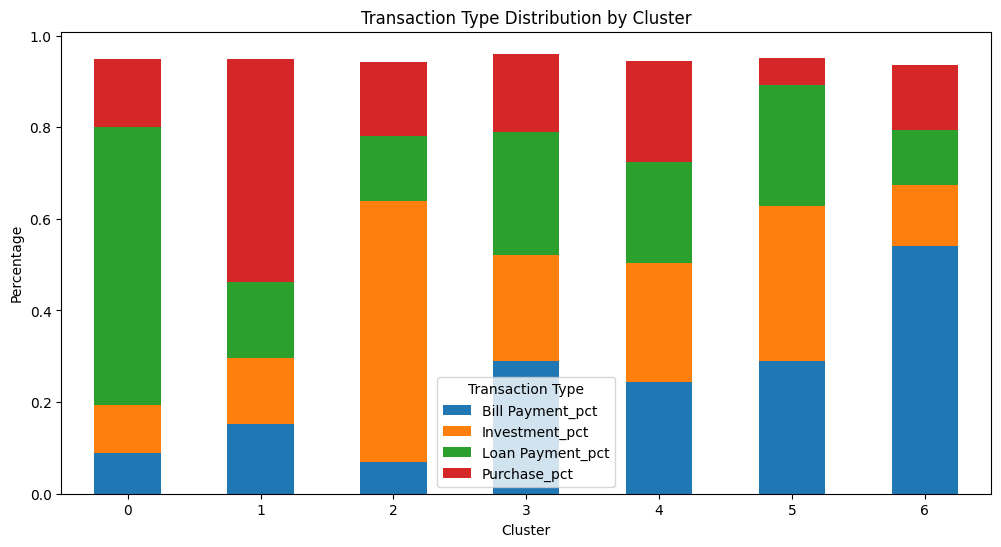

CUSTOMER SEGMENT PROFILES:
         Size  Avg Transaction  Total Spent  Transaction Count  Satisfaction  \
cluster                                                                        
0         122         2618.980    10722.560              4.090         5.350   
1         181         2382.560    12215.820              5.060         5.240   
2         184         2521.310     9752.490              3.860         5.380   
3         182         2964.570    23881.450              8.090         5.460   
4         111         2501.850    13525.270              5.490         7.450   
5           6        81766.130   409980.970              5.500         5.880   
6         207         2512.330     9153.950              3.670         5.390   

         Recommendation Main Transaction  \
cluster                                    
0                 5.830     Loan Payment   
1                 5.740         Purchase   
2                 5.530       Investment   
3                 5.470     Bill

In [18]:
# 5.1 Analyzing Cluster Characteristics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate cluster profiles (mean values for each feature by cluster)
cluster_profiles = combined_features.groupby('cluster').mean()

# 2. Create a heatmap of cluster characteristics
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_profiles.drop(['Customer_ID'], axis=1, errors='ignore'),
            cmap="YlGnBu", annot=False, fmt='.2f')
plt.title('Heatmap of Cluster Characteristics', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Radar charts to visualize each cluster's profile
from math import pi

# Select key features for the radar chart
key_features = ['avg_transaction_amount', 'total_spent', 'transaction_count',
                'Bill Payment_pct', 'Investment_pct', 'Loan Payment_pct', 'Purchase_pct',
                'satisfaction_avg', 'recommendation_avg']

# Function to create a radar chart for a specific cluster
def create_radar_chart(cluster_num, key_features, cluster_profiles, ax=None):
    # Number of variables
    N = len(key_features)

    # Get the values for the cluster
    values = cluster_profiles.loc[cluster_num, key_features].values.tolist()

    # Normalize values to 0-1 scale for comparison
    max_values = cluster_profiles[key_features].max()
    min_values = cluster_profiles[key_features].min()
    normalized_values = [(val - min_val) / (max_val - min_val) if max_val > min_val else 0.5
                         for val, min_val, max_val in zip(values, min_values, max_values)]

    # Repeat the first value to close the circle
    values_with_closure = normalized_values + [normalized_values[0]]

    # Calculate angles for each feature
    angles = [n / N * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the circle

    # Create the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw the plot
    ax.plot(angles, values_with_closure, linewidth=2, linestyle='solid')
    ax.fill(angles, values_with_closure, alpha=0.25)

    # Add feature labels
    plt.xticks(angles[:-1], key_features, size=10)

    # Set y-axis limits
    ax.set_ylim(0, 1)

    # Add title
    plt.title(f'Cluster {cluster_num} Profile', size=15, y=1.1)

    return ax

# Create radar charts for all clusters
fig = plt.figure(figsize=(20, 15))
num_clusters = len(cluster_profiles)

for i in range(num_clusters):
    ax = fig.add_subplot(3, 3, i+1, polar=True)
    create_radar_chart(i, key_features, cluster_profiles, ax)

plt.tight_layout()
plt.show()

# 4. Bar charts comparing key metrics across clusters
key_metrics = ['avg_transaction_amount', 'total_spent', 'transaction_count',
              'satisfaction_avg', 'recommendation_avg']

fig, axes = plt.subplots(len(key_metrics), 1, figsize=(12, 15))
for i, metric in enumerate(key_metrics):
    sns.barplot(x=cluster_profiles.index, y=cluster_profiles[metric], ax=axes[i])
    axes[i].set_title(f'Average {metric} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

# 5. Transaction type distribution by cluster
transaction_types = ['Bill Payment_pct', 'Investment_pct', 'Loan Payment_pct', 'Purchase_pct']
transaction_type_data = cluster_profiles[transaction_types]

# Create stacked bar chart
transaction_type_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Transaction Type Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Transaction Type')
plt.xticks(rotation=0)
plt.show()

# 6. Summary table of cluster characteristics with interpretation
def interpret_cluster(profile):
    """Generate interpretation based on cluster profile"""
    interpretation = []

    # Transaction amount
    if profile['avg_transaction_amount'] > cluster_profiles['avg_transaction_amount'].mean():
        interpretation.append("Higher than average transaction amounts")
    else:
        interpretation.append("Lower than average transaction amounts")

    # Total spent
    if profile['total_spent'] > cluster_profiles['total_spent'].mean():
        interpretation.append("Higher total spending")
    else:
        interpretation.append("Lower total spending")

    # Transaction count
    if profile['transaction_count'] > cluster_profiles['transaction_count'].mean():
        interpretation.append("More frequent transactions")
    else:
        interpretation.append("Less frequent transactions")

    # Dominant transaction type
    transaction_pcts = {
        'Bill Payments': profile['Bill Payment_pct'],
        'Investments': profile['Investment_pct'],
        'Loan Payments': profile['Loan Payment_pct'],
        'Purchases': profile['Purchase_pct']
    }
    dominant_type = max(transaction_pcts, key=transaction_pcts.get)
    interpretation.append(f"Primarily uses {dominant_type}")

    # Satisfaction
    if profile['satisfaction_avg'] > cluster_profiles['satisfaction_avg'].mean():
        interpretation.append("Above average satisfaction")
    else:
        interpretation.append("Below average satisfaction")

    # Recommendation
    if profile['recommendation_avg'] > cluster_profiles['recommendation_avg'].mean():
        interpretation.append("More likely to recommend")
    else:
        interpretation.append("Less likely to recommend")

    return ", ".join(interpretation)

# Create interpretation summary
summary = pd.DataFrame(index=cluster_profiles.index)
summary['Size'] = combined_features['cluster'].value_counts().sort_index()
summary['Avg Transaction'] = cluster_profiles['avg_transaction_amount'].round(2)
summary['Total Spent'] = cluster_profiles['total_spent'].round(2)
summary['Transaction Count'] = cluster_profiles['transaction_count'].round(2)
summary['Satisfaction'] = cluster_profiles['satisfaction_avg'].round(2)
summary['Recommendation'] = cluster_profiles['recommendation_avg'].round(2)
summary['Main Transaction'] = cluster_profiles[transaction_types].idxmax(axis=1).str.replace('_pct', '')
summary['Interpretation'] = [interpret_cluster(profile) for _, profile in cluster_profiles.iterrows()]

# Display the summary
print("CUSTOMER SEGMENT PROFILES:")
print(summary)

# 7. Suggest product recommendations based on cluster profiles
def suggest_products(profile):
    """Generate product recommendations based on cluster characteristics"""
    suggestions = []

    # High-value customers
    if profile['total_spent'] > cluster_profiles['total_spent'].quantile(0.75):
        suggestions.append("Premium credit card with enhanced rewards")
        suggestions.append("Wealth management services")

    # Frequent transactors
    if profile['transaction_count'] > cluster_profiles['transaction_count'].quantile(0.75):
        suggestions.append("No-fee checking account with unlimited transactions")
        suggestions.append("Mobile banking app with advanced features")

    # Investment-focused
    if profile['Investment_pct'] > cluster_profiles['Investment_pct'].quantile(0.75):
        suggestions.append("Robo-advisor investment platform")
        suggestions.append("Tax-advantaged investment accounts")

    # Loan-focused
    if profile['Loan Payment_pct'] > cluster_profiles['Loan Payment_pct'].quantile(0.75):
        suggestions.append("Loan consolidation services")
        suggestions.append("Automated payment scheduling")

    # Low satisfaction
    if profile['satisfaction_avg'] < cluster_profiles['satisfaction_avg'].quantile(0.25):
        suggestions.append("Personalized customer service program")
        suggestions.append("Account review and optimization consultation")

    # Default recommendations if none of the above apply
    if not suggestions:
        suggestions.append("Basic savings account with competitive interest rate")
        suggestions.append("Standard checking account")

    return suggestions

# Add product recommendations to summary
summary['Product Recommendations'] = [
    ", ".join(suggest_products(profile)[:2]) for _, profile in cluster_profiles.iterrows()
]

print("\nRECOMMENDED PRODUCTS BY SEGMENT:")
for cluster, row in summary.iterrows():
    print(f"\nCluster {cluster} - {row['Interpretation']}")
    print(f"Recommended Products: {row['Product Recommendations']}")

# 8. Export results to CSV for further analysis
summary.to_csv('customer_segment_profiles.csv')
print("\nCustomer segment profiles exported to 'customer_segment_profiles.csv'")